In [1]:
import SimpleITK as sitk
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from ipywidgets import interact, fixed
import os
import time

fixed_path = 'MR.bmp'
moving_path = 'CT.bmp'

fixed = sitk.ReadImage(fixed_path, sitk.sitkFloat64)
moving = sitk.ReadImage(moving_path, sitk.sitkFloat64)

(250, 250)

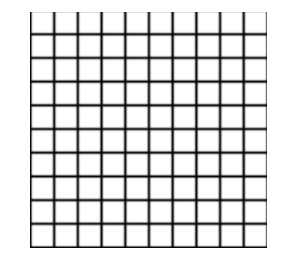

In [2]:
def myshow(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayViewFromImage(img)
    spacing = img.GetSpacing()
    ysize = nda.shape[0]
    xsize = nda.shape[1]
    
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi
    
    fig = plt.figure(title, figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    
    extent = (0, xsize*spacing[1], 0, ysize*spacing[0])
    ax.axis('off')
    t = ax.imshow(nda,
                  extent=extent,
                  interpolation='hamming',
                  cmap='gray',
                  origin='lower')
    
    if(title):
        plt.title(title)
        
grid = sitk.GridSource(outputPixelType=sitk.sitkFloat64,
                       size=(250, 250),
                       sigma=(0.2, 0.2),
                       gridSpacing=(5., 5.),
                       gridOffset=(0., 0.),
                       spacing=(0.2, 0.2))

moving = grid
myshow(moving)
moving.GetSize()

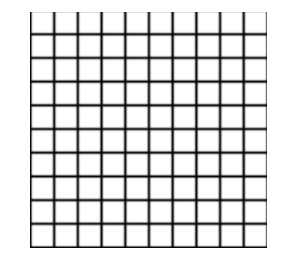

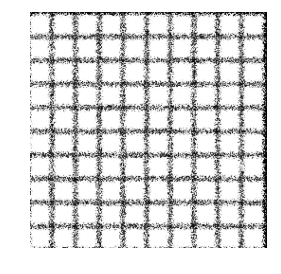

In [3]:
displacement = sitk.DisplacementFieldTransform(2)
field_size = [250,250]
field_origin = list(grid.GetOrigin())
field_spacing = [0.2, 0.2]   
field_direction = [1,0,0,1] # direction cosine matrix (row major order) 

displacement.SetFixedParameters(field_size+field_origin+field_spacing+field_direction)
displacement.SetInterpolator(sitk.sitkNearestNeighbor)

originalDisplacements = np.random.random(len(displacement.GetParameters()))
displacement.SetParameters(originalDisplacements)

# print(displacement)

transformed_img = sitk.Resample(grid, displacement)
myshow(grid)
myshow(transformed_img)

itk::simple::BSplineTransform
 BSplineTransform (0x55cd41e5a5b0)
   RTTI typeinfo:   itk::BSplineTransform<double, 2u, 3u>
   Reference Count: 1
   Modified Time: 1264
   Debug: Off
   Object Name: 
   Observers: 
     none
   CoefficientImage: [ 0x55cd415b5f30, 0x55cd41ec7140 ]
   TransformDomainOrigin: [0, 0]
   TransformDomainPhysicalDimensions: [232, 320]
   TransformDomainDirection: 1 0
0 1

   GridSize: [28, 28]
   GridOrigin: [-9.28, -12.8]
   GridSpacing: [9.28, 12.8]
   GridDirection: 1 0
0 1




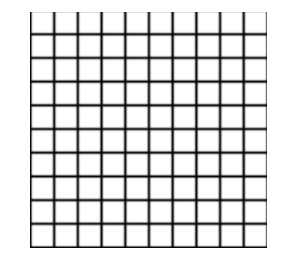

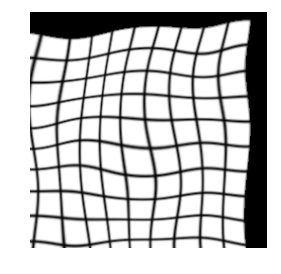

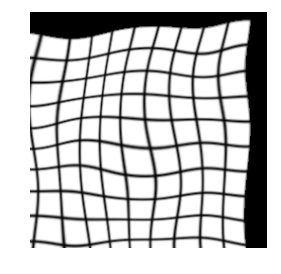

In [4]:
np.random.seed(1)

grid = moving

dimension = 2
spline_order = 3
direction_matrix_row_major = [1., 0., 0., 1.] # identity, mesh is axis aligned
origin = grid.GetOrigin()
domain_physical_dimension = [232, 320]

bspline = sitk.BSplineTransform(dimension, spline_order)
bspline.SetTransformDomainOrigin(origin)
bspline.SetTransformDomainDirection(direction_matrix_row_major)
bspline.SetTransformDomainPhysicalDimensions(domain_physical_dimension)
bspline.SetTransformDomainMeshSize((25, 25))

originalControlPointDisplacements = np.random.random(len(bspline.GetParameters()))*8
bspline.SetParameters(originalControlPointDisplacements)

# print(min(originalControlPointDisplacements), max(originalControlPointDisplacements))
print(bspline)
# print(np.shape(bspline.GetParameters()))

transformed_img = sitk.Resample(grid, bspline)
# myshow(fixed)
myshow(grid)
myshow(transformed_img)

transform_to_displacement_filter = sitk.TransformToDisplacementFieldFilter()
transform_to_displacement_filter.SetReferenceImage(grid)
displacement_transform = sitk.DisplacementFieldTransform(transform_to_displacement_filter.Execute(bspline))
displacement_transform.SetSmoothingGaussianOnUpdate(varianceForUpdateField=0.0, varianceForTotalField=2.0)
# print(displacement_transform)
moved_grid = sitk.Resample(grid, displacement_transform)

myshow(moved_grid)

(250, 250)


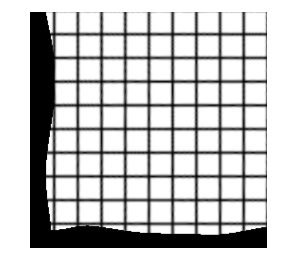

In [5]:
displacement_field = displacement_transform.GetDisplacementField()
inverse_displacement_field = sitk.InverseDisplacementField(displacement_field,
                                                           displacement_field.GetSize(),
                                                           grid.GetOrigin(),
                                                           displacement_field.GetSpacing(), 8)
print(inverse_displacement_field.GetSize())
inverse_displacement_transform = sitk.DisplacementFieldTransform(inverse_displacement_field)
inverse_displacement_transform.SetSmoothingGaussianOnUpdate(varianceForUpdateField=0.0, varianceForTotalField=2.0)
inversed_grid = sitk.Resample(moved_grid, inverse_displacement_transform)
myshow(inversed_grid)

In [ ]:
print(inverse_displacement_transform.GetDisplacementField().GetSize())